In [1]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false 
#Caleb's magical words to prevent memory error, disables JAX?

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [2]:
from jax_moseq.utils import set_mixed_map_iters
set_mixed_map_iters(3) #reduces computatoinal power but takes longer

In [3]:
import keypoint_moseq
import keypoint_moseq as kpms
#from keypoint_moseq.io import load_results
print(keypoint_moseq.__version__)#should ONLY print 0.5 version

0.5.0


In [4]:
import os
import glob
import h5py
import pandas as pd
import numpy as np
import copy

In [5]:
#for already trained model, load project directly, config file and pca
project_dir = "/home/nj35/MRes/moseq_project/3CT_model"

In [6]:
config = lambda: kpms.load_config(project_dir)

## pre-processing

In [7]:
#load data (e.g from DeepLabCut)
keypoint_data_path = [
    '/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/3CT',
    '/home/nj35/MRes/TDP videos/Cohort 1/post-induction-w1/3CT',
    '/home/nj35/MRes/TDP videos/Cohort 1/post-induction-w2/3CT',
    '/home/nj35/MRes/TDP videos/Cohort 3/pre-induction/3CT',
    '/home/nj35/MRes/TDP videos/Cohort 3/post-induction-w1/3CT',
    '/home/nj35/MRes/TDP videos/Cohort 3/post-induction-w2/3CT'
]  # can be a file, a directory, or a list of files

In [8]:
# Function to find all .h5 files in specified directories
def find_h5_files(keypoint_data_path):
    h5_files = []  
    for directory in keypoint_data_path:
        pattern = os.path.join(directory, '*.h5')  # Look only in the specified folders (no recursion)
        h5_files.extend(glob.glob(pattern))  
    return h5_files

In [9]:
# Get list of .h5 files from the given directories
h5_files = find_h5_files(keypoint_data_path)
print(f"Number of .h5 files found: {len(h5_files)}")
print("Found .h5 files:", h5_files)
#should be 93 for 3CT

Number of .h5 files found: 102
Found .h5 files: ['/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/3CT/pre-induction_3CT_fixed_14_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5', '/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/3CT/pre-induction_3CT_fixed_10_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5', '/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/3CT/pre-induction_3CT_fixed_11_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5', '/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/3CT/pre-induction_3CT_fixed_16_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5', '/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/3CT/pre-induction_3CT_fixed_12_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5', '/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/3CT/pre-induction_3CT_fixed_15_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5', '/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/3CT/pre-induction_

In [10]:
# Process each .h5 file: filter and overwrite it in the same location
for h5_file_3CT in h5_files:
    try:
        print(f"Processing: {h5_file_3CT}")

        # Load the existing .h5 file
        df_3CT = pd.read_hdf(h5_file_3CT)

        # Apply filtering: Keep only 'animal0'
        df_filtered_3CT = df_3CT.loc[:, df_3CT.columns.get_level_values('individuals') == 'animal0']

        # Overwrite the same file with filtered data
        df_filtered_3CT.to_hdf(h5_file_3CT, key='df', mode='w')

        print(f"Filtered and saved: {h5_file_3CT}")

    except Exception as e:
        print(f"Error processing {h5_file_3CT}: {e}")

Processing: /home/nj35/MRes/TDP videos/Cohort 1/pre-induction/3CT/pre-induction_3CT_fixed_14_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5
Filtered and saved: /home/nj35/MRes/TDP videos/Cohort 1/pre-induction/3CT/pre-induction_3CT_fixed_14_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5
Processing: /home/nj35/MRes/TDP videos/Cohort 1/pre-induction/3CT/pre-induction_3CT_fixed_10_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5
Filtered and saved: /home/nj35/MRes/TDP videos/Cohort 1/pre-induction/3CT/pre-induction_3CT_fixed_10_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5
Processing: /home/nj35/MRes/TDP videos/Cohort 1/pre-induction/3CT/pre-induction_3CT_fixed_11_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5
Filtered and saved: /home/nj35/MRes/TDP videos/Cohort 1/pre-induction/3CT/pre-induction_3CT_fixed_11_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5
Processing: /home/nj35/MRes/TDP videos/C

In [ ]:
# snapshot detector path
h5_path = "/home/nj35/MRes/TDP videos/post-induction-w1/3CT/post-induction-w1_3CT_fixed_1_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5"
epm_h5 = pd.read_hdf(h5_path)
# .csv output file path
csv_path = "/home/nj35/MRes/TDP videos/post-induction-w1/3CT/post-induction-w1_3CT_fixed_1_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.csv"
epm_h5.to_csv(csv_path, index=True)

print(f"CSV file saved at: {csv_path}")

## 3CT Model

In [11]:
# Define bodyparts and skeleton
bodyparts = [
    'nose', 'left_ear', 'right_ear', 'left_ear_tip', 'right_ear_tip',
    'left_eye', 'right_eye', 'neck', 'mid_back', 'mouse_center',
    'mid_backend', 'mid_backend2', 'mid_backend3', 'tail_base',
    'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'left_shoulder',
    'left_midside', 'left_hip', 'right_shoulder', 'right_midside',
    'right_hip', 'tail_end', 'head_midpoint'
]

skeleton = [
    ['nose', 'left_eye'],
    ['nose', 'right_eye'],
    ['nose', 'left_ear'],
    ['nose', 'right_ear'],
    ['left_eye', 'right_eye'],
    ['left_ear', 'left_ear_tip'],
    ['right_ear', 'right_ear_tip'],
    ['left_ear', 'head_midpoint'],
    ['right_ear', 'head_midpoint'],
    ['neck', 'left_shoulder'],
    ['neck', 'right_shoulder'],
    ['neck', 'mid_back'],
    ['left_shoulder', 'left_hip'],
    ['right_shoulder', 'right_hip'],
    ['left_hip', 'left_midside'],
    ['right_hip', 'right_midside'],
    ['left_midside', 'mid_back'],
    ['right_midside', 'mid_back'],
    ['mid_back', 'mouse_center'],
    ['mouse_center', 'mid_backend'],
    ['mouse_center', 'mid_backend2'],
    ['mouse_center', 'mid_backend3'],
    ['mid_backend', 'mid_backend2'],
    ['mid_backend2', 'mid_backend3'],
    ['mid_backend2', 'tail_base'],
    ['mid_backend3', 'tail_base'],
    ['tail_base', 'tail1'],
    ['tail1', 'tail2'],
    ['tail2', 'tail3'],
    ['tail3', 'tail4'],
    ['tail4', 'tail5'],
    ['tail5', 'tail_end'],
    ['head_midpoint', 'neck']
]

In [12]:
video_dir = [
    '/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/3CT',
    '/home/nj35/MRes/TDP videos/Cohort 1/post-induction-w1/3CT',
    '/home/nj35/MRes/TDP videos/Cohort 1/post-induction-w2/3CT',
    '/home/nj35/MRes/TDP videos/Cohort 3/pre-induction/3CT',
    '/home/nj35/MRes/TDP videos/Cohort 3/post-induction-w1/3CT',
    '/home/nj35/MRes/TDP videos/Cohort 3/post-induction-w2/3CT'
] 

In [13]:
# Set up the project
kpms.setup_project(
    overwrite=True,
    project_dir=project_dir, # decides where demo project is created
    video_dir=video_dir,
    bodyparts=bodyparts,
    skeleton=skeleton
)

In [14]:
kpms.update_config(
    project_dir,
    video_dir=[
    '/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/3CT',
    '/home/nj35/MRes/TDP videos/Cohort 1/post-induction-w1/3CT',
    '/home/nj35/MRes/TDP videos/Cohort 1/post-induction-w2/3CT',
    '/home/nj35/MRes/TDP videos/Cohort 3/pre-induction/3CT',
    '/home/nj35/MRes/TDP videos/Cohort 3/post-induction-w1/3CT',
    '/home/nj35/MRes/TDP videos/Cohort 3/post-induction-w2/3CT'],
    anterior_bodyparts=["nose"],
    posterior_bodyparts=["tail_base"],
    use_bodyparts = [
    "nose",
    "head_midpoint",
    "left_ear",
    "right_ear",
    "neck",
    "mid_back",
    "mouse_center",
    "mid_backend2",
    "tail_base"],
)

In [15]:
### Caleb's advice for excluding likelihoods <0.3 including when mouse in in dark and not recognised

coordinates, confidences, bodyparts = kpms.load_keypoints(keypoint_data_path, 'deeplabcut', recursive=False, extension='.h5')

coordinates = {k : np.where(confidences[k][:,:,None] < 0.3, np.nan, coordinates[k]) for k in coordinates} #changes values less than 0.6 to NaN

data, metadata = kpms.format_data(coordinates, confidences, **config()) #format data for analysing

Loading keypoints: 100%|██████████████| 102/102 [00:02<00:00, 50.93it/s]


>=90.0% of variance exlained by 7 components.


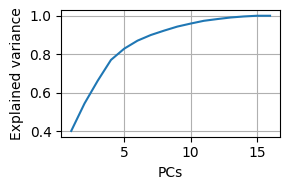

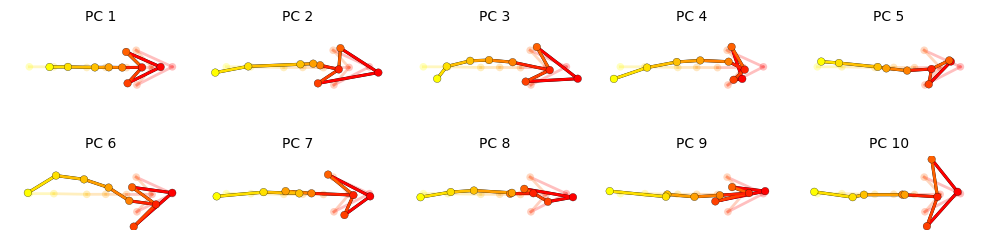

In [16]:
pca = kpms.fit_pca(**data, **config())
kpms.save_pca(pca, project_dir)

kpms.print_dims_to_explain_variance(pca, 0.9)
kpms.plot_scree(pca, project_dir=project_dir)
kpms.plot_pcs(pca, project_dir=project_dir, **config())

In [17]:
kpms.update_config(project_dir, latent_dim=7)

In [18]:
model = kpms.init_model(data, pca=pca, **config())

Outputs will be saved to
/home/nj35/MRes/moseq_project/3CT_model/2025_04_23-09_11_13


 49%|█████████████████▏                 | 25/51 [03:09<03:14,  7.46s/it]

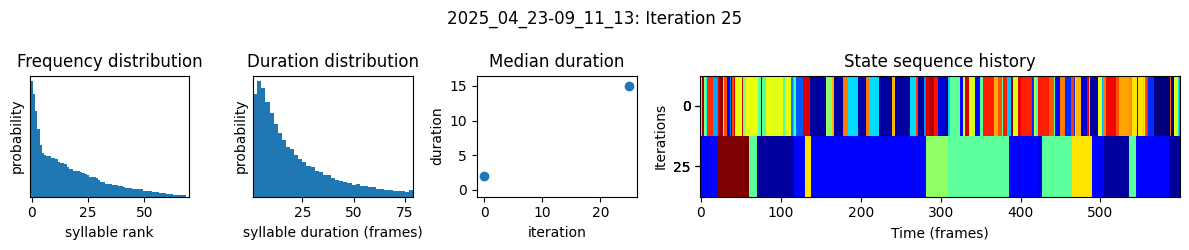

 98%|██████████████████████████████████▎| 50/51 [06:16<00:07,  7.48s/it]

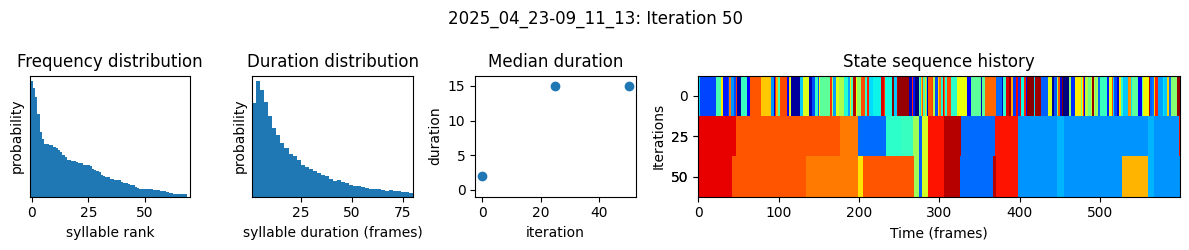

100%|███████████████████████████████████| 51/51 [06:25<00:00,  7.56s/it]


In [19]:
# optionally modify kappa
model = kpms.update_hypparams(model, kappa=5e6) #originally 1e4 for 20 median frames at 50 fps = 400ms syllable duration. 2e4 is 800ms?

num_ar_iters = 50

model, model_name = kpms.fit_model( #you can change model_name for AR-HMM which links to full model
    model, data, metadata, project_dir,
    ar_only=True, num_iters=num_ar_iters)


In [20]:
# load model_5e6_1e6 checkpoint
model, data, metadata, current_iter = kpms.load_checkpoint(project_dir, model_name="model_5e6_1e6")

Outputs will be saved to
/home/nj35/MRes/moseq_project/3CT_model/model_5e6_1e6


  5%|█▌                              | 25/501 [10:44<3:16:15, 24.74s/it]

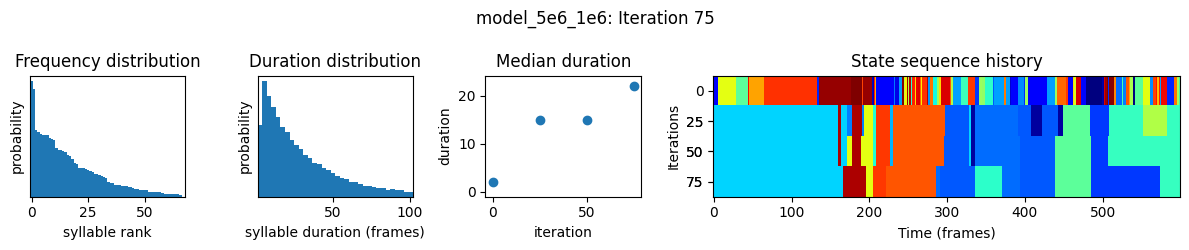

 10%|███▏                            | 50/501 [21:03<3:05:39, 24.70s/it]

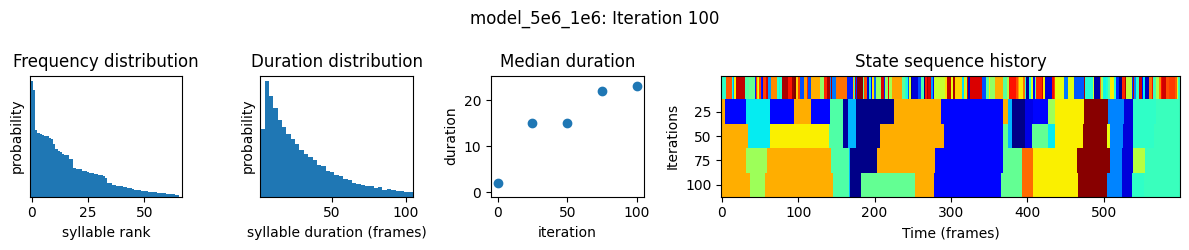

 15%|████▊                           | 75/501 [31:22<2:55:23, 24.70s/it]

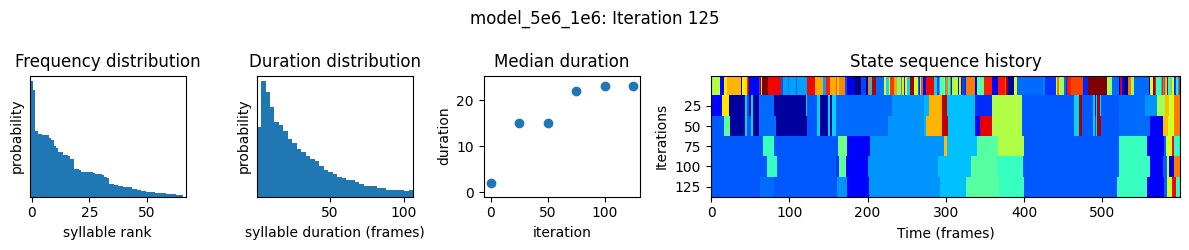

 20%|██████▏                        | 100/501 [41:41<2:45:07, 24.71s/it]

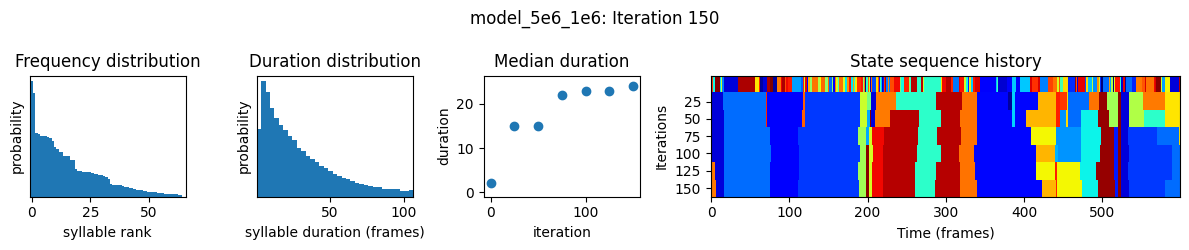

 25%|███████▋                       | 125/501 [52:00<2:34:57, 24.73s/it]

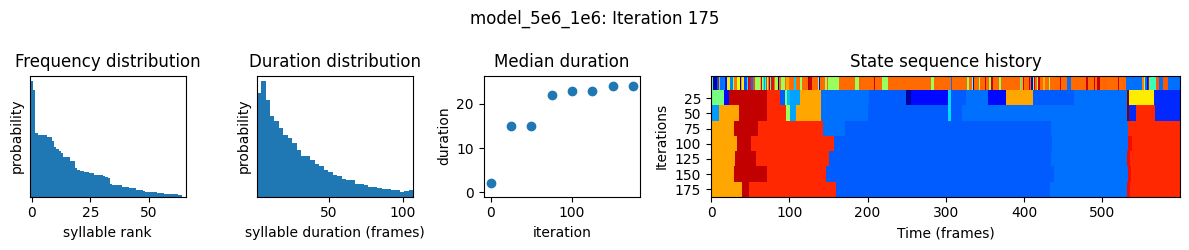

 30%|████████▋                    | 150/501 [1:02:18<2:24:38, 24.72s/it]

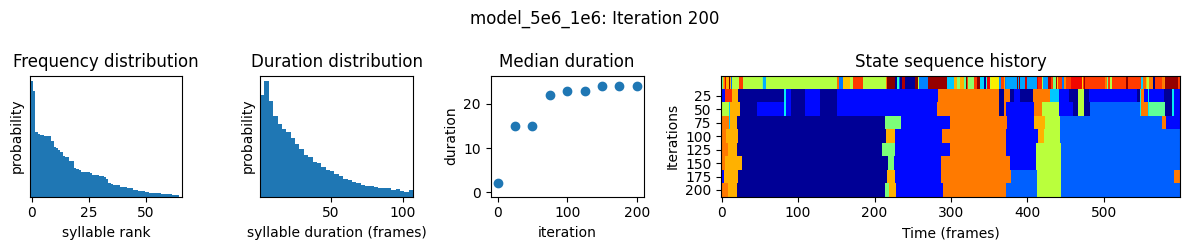

 35%|██████████▏                  | 175/501 [1:12:37<2:14:07, 24.69s/it]

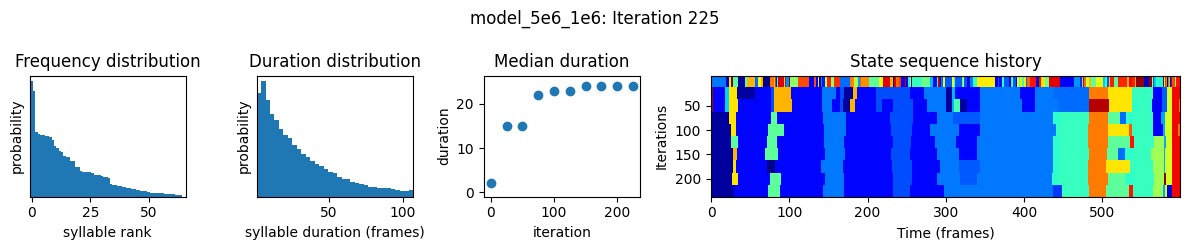

 40%|███████████▌                 | 200/501 [1:22:55<2:03:54, 24.70s/it]

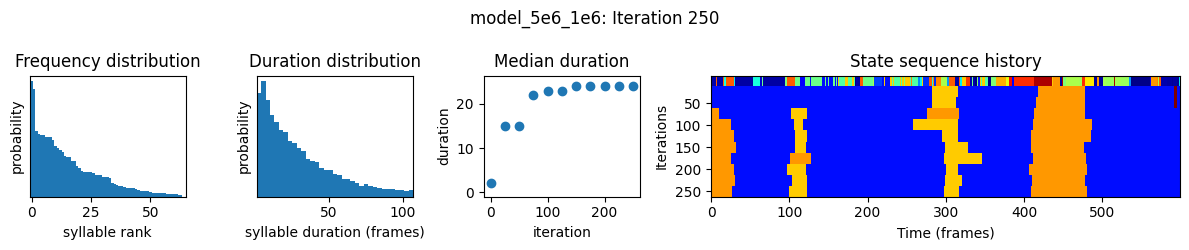

 45%|█████████████                | 225/501 [1:33:14<1:53:31, 24.68s/it]

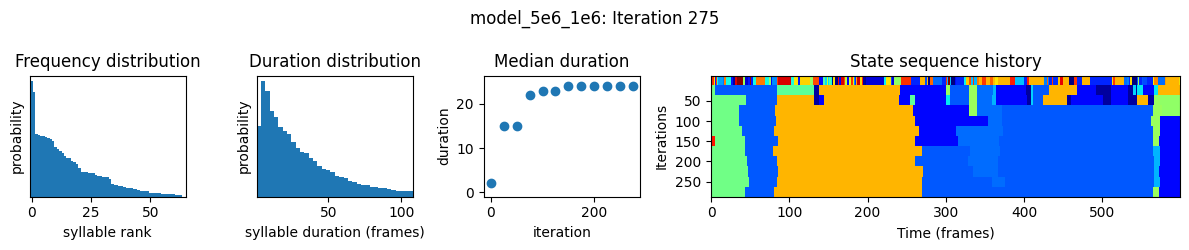

 50%|██████████████▍              | 250/501 [1:43:32<1:43:19, 24.70s/it]

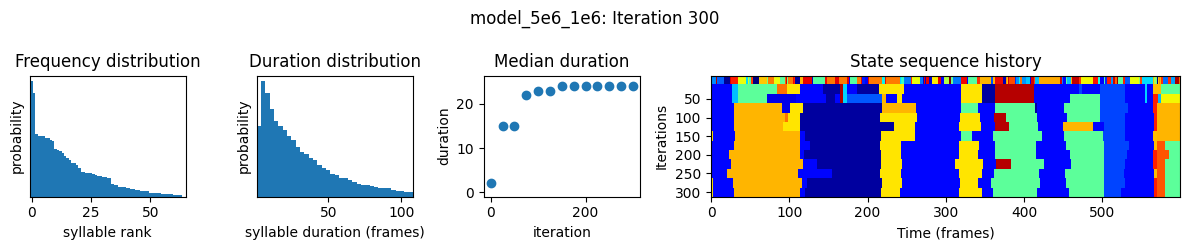

 55%|███████████████▉             | 275/501 [1:53:51<1:32:58, 24.68s/it]

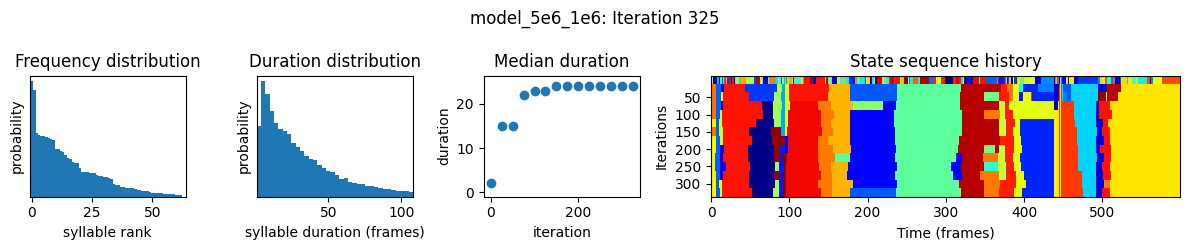

 60%|█████████████████▎           | 300/501 [2:04:09<1:22:40, 24.68s/it]

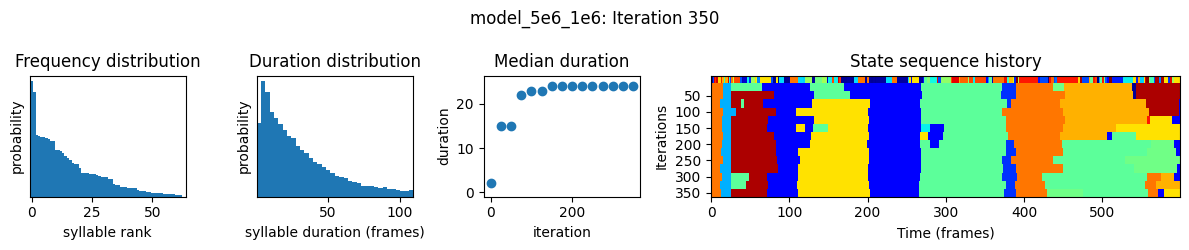

 65%|██████████████████▊          | 325/501 [2:14:28<1:12:24, 24.69s/it]

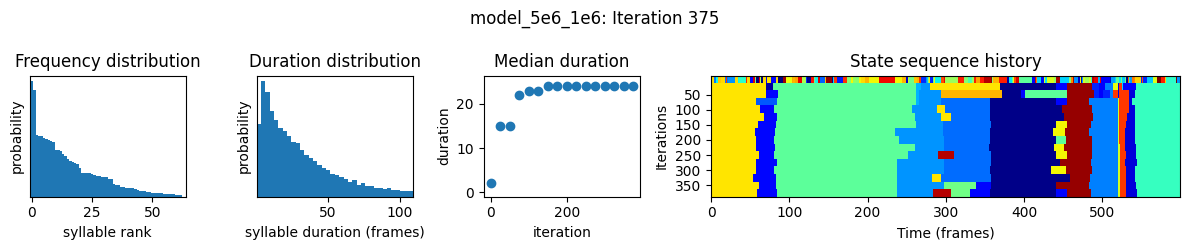

 70%|████████████████████▎        | 350/501 [2:24:46<1:02:07, 24.69s/it]

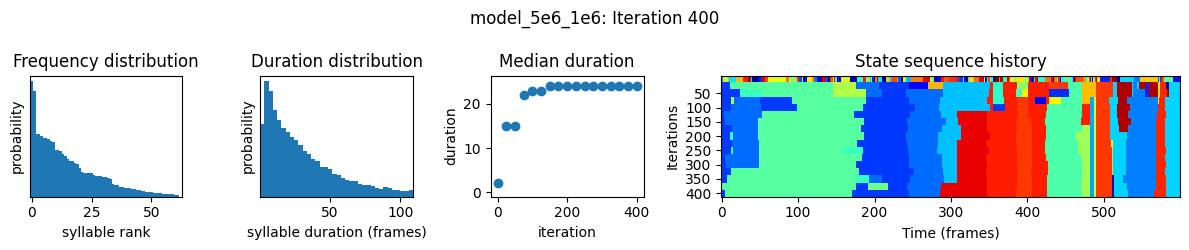

 75%|███████████████████████▏       | 375/501 [2:35:05<51:51, 24.69s/it]

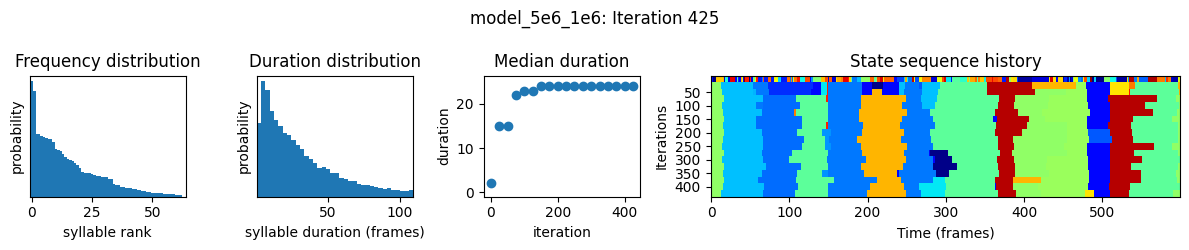

 80%|████████████████████████▊      | 400/501 [2:45:23<41:33, 24.69s/it]

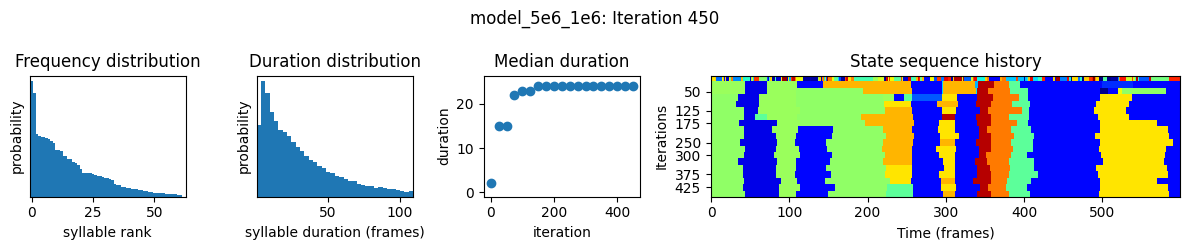

 85%|██████████████████████████▎    | 425/501 [2:55:42<31:16, 24.69s/it]

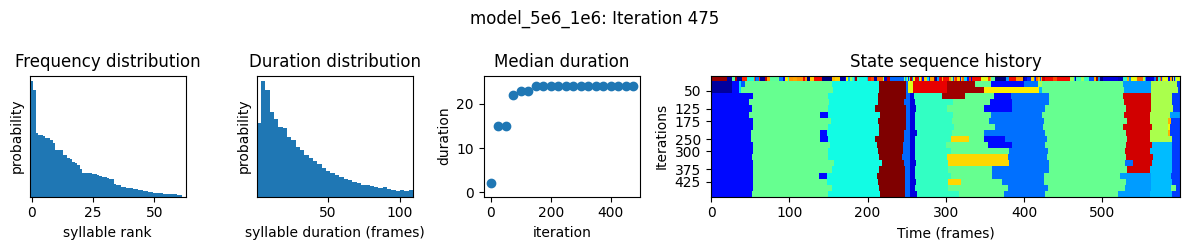

 90%|███████████████████████████▊   | 450/501 [3:06:01<20:58, 24.68s/it]

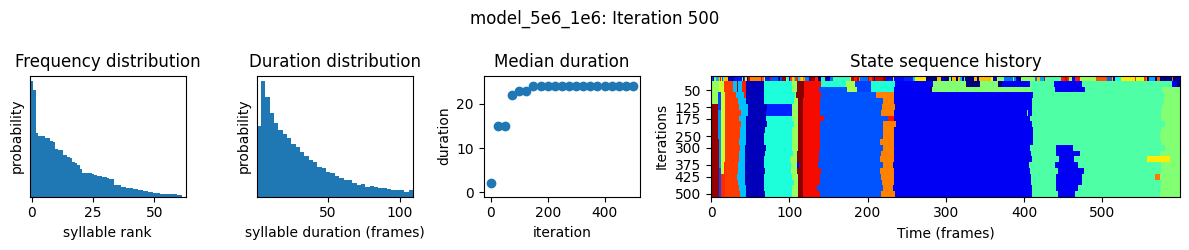

 95%|█████████████████████████████▍ | 475/501 [3:16:19<10:41, 24.69s/it]

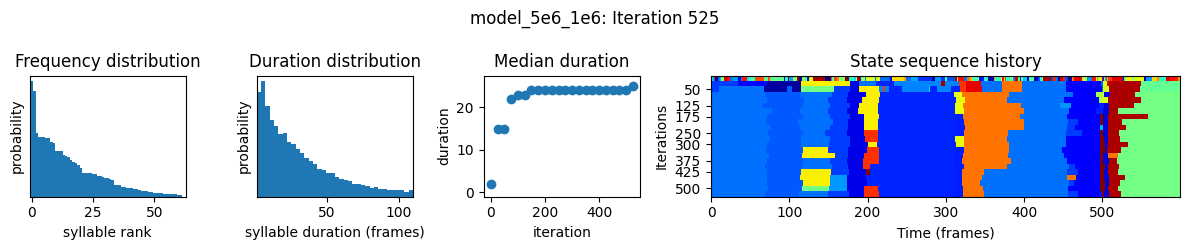

100%|██████████████████████████████▉| 500/501 [3:26:38<00:24, 24.68s/it]

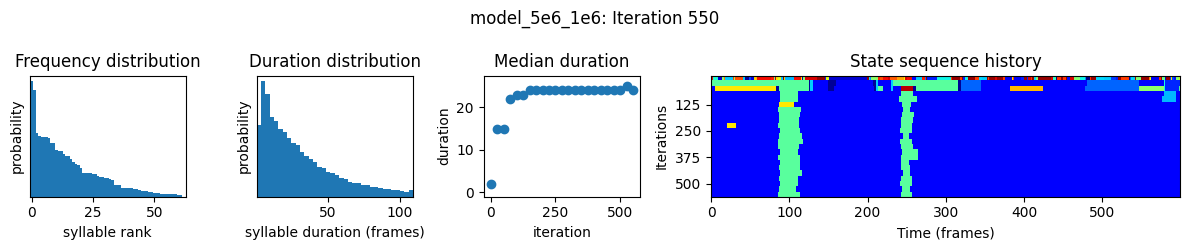

100%|███████████████████████████████| 501/501 [3:27:04<00:00, 24.80s/it]


In [21]:
# modify kappa to maintain the desired syllable time-scale
model = kpms.update_hypparams(model, kappa=1e6)

# run fitting for an additional 500 iters
model = kpms.fit_model(
    model, data, metadata, project_dir, model_name="model_5e6_1e6", ar_only=False, #2e4 in this line refers to AR-HMM model
    start_iter=current_iter, num_iters=current_iter+500)[0]

In [22]:
# modify a saved checkpoint so syllables are ordered by frequency
kpms.reindex_syllables_in_checkpoint(project_dir, model_name="model_5e6_1e6");

Reindexing: 100%|███████████| 23/23 [00:10<00:00,  2.23model snapshot/s]


In [23]:
# load the most recent model checkpoint
model, data, metadata, current_iter = kpms.load_checkpoint(project_dir, model_name="model_5e6_1e6")

# extract results
results = kpms.extract_results(model, metadata, project_dir, model_name="model_5e6_1e6")

Saved results to
/home/nj35/MRes/moseq_project/3CT_model/model_5e6_1e6/results.h5


Saving trajectory plots to /home/nj35/MRes/moseq_project/3CT_model/model_5e6_1e6/trajectory_plots


Generating trajectory plots: 100%|██████| 44/44 [00:15<00:00,  2.92it/s]


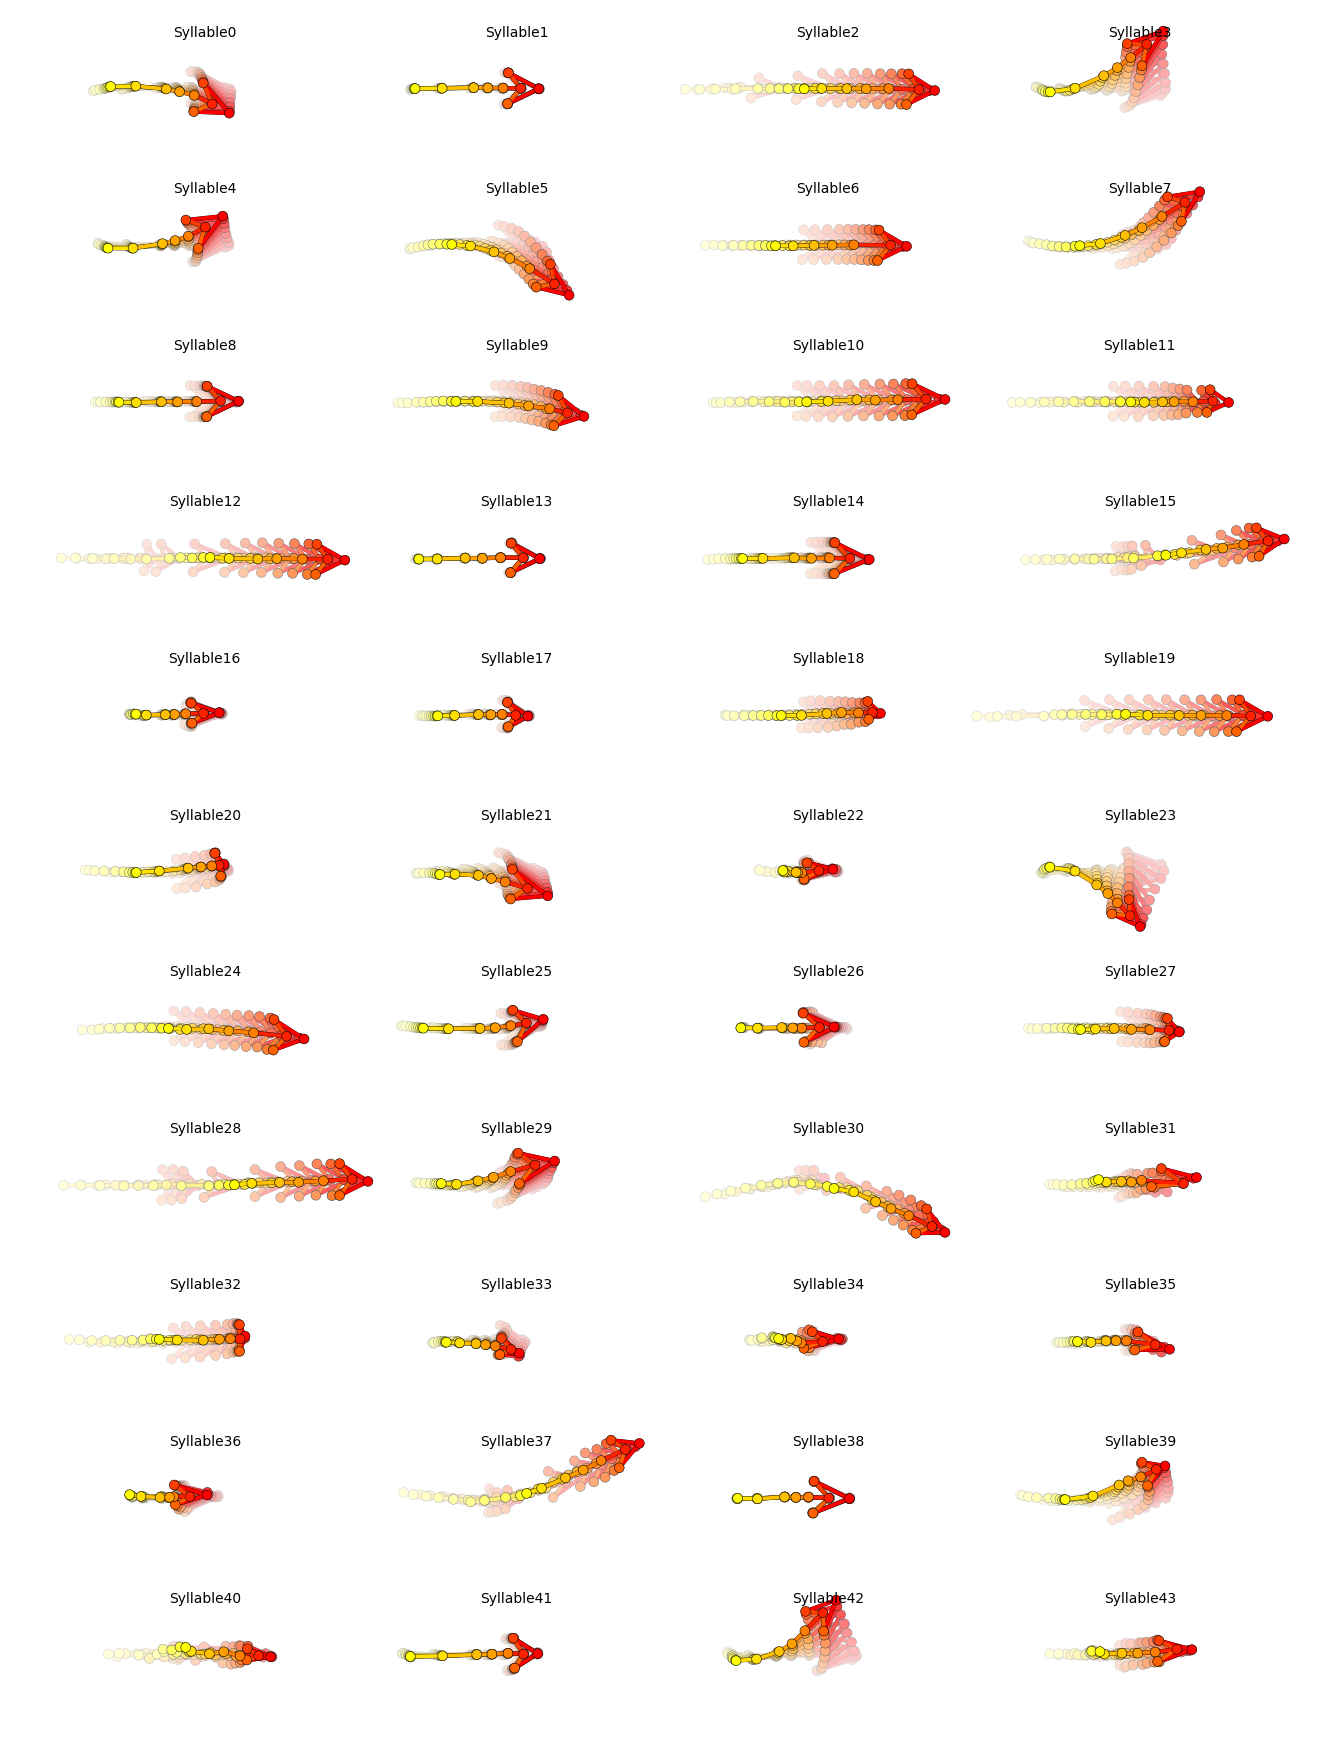

In [24]:
results = kpms.load_results(project_dir, model_name="model_5e6_1e6")
kpms.generate_trajectory_plots(coordinates, results, project_dir, model_name="model_5e6_1e6",  density_sample=False, **config())

In [25]:
kpms.generate_grid_movies(
    results, 
    project_dir, 
    model_name="model_5e6_1e6", 
    coordinates=coordinates, 
    pre=50, 
    post=100, 
    **config()
);

Writing grid movies to /home/nj35/MRes/moseq_project/3CT_model/model_5e6_1e6/grid_movies


/home/nj35/miniforge3/envs/keypoint_moseq/lib/python3.9/site-packages/keypoint_moseq/viz.py:1282: UserWarning:


Videos will be downscaled by a factor of 0.71 so that the grid movies
are under 1920 pixels. Use `max_video_size` to increase or decrease
this size limit.





Using window size of 448 pixels


Generating grid movies: 100%|███████████| 44/44 [14:14<00:00, 19.42s/it]


Saving dendrogram plot to /home/nj35/MRes/moseq_project/3CT_model/model_5e6_1e6/similarity_dendrogram


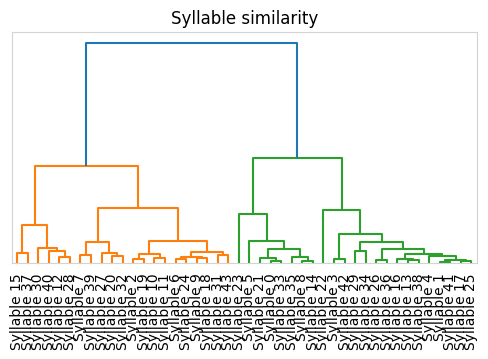

In [26]:
# Plot a dendrogram representing distances between each syllable’s median trajectory.
kpms.plot_similarity_dendrogram(coordinates, results, project_dir, model_name="model_5e6_1e6", **config())

In [27]:
kpms.interactive_group_setting(project_dir, model_name="model_5e6_1e6")

Row
    [0] Tabulator(editors={'name': None, ...}, show_index=False, titles={'name': 'recording name',...}, value=              ..., widths={'name': 400})
    [1] Column
        [0] Button(button_type='primary', name='Save group info')

In [28]:
moseq_3CT = kpms.compute_moseq_df(project_dir, model_name="model_5e6_1e6", fps=50, smooth_heading=True) 
moseq_3CT

name  centroid_x  \
0        post-induction-w1_3CT_fixed_10_superanimal_top...  388.868235   
1        post-induction-w1_3CT_fixed_10_superanimal_top...  386.234022   
2        post-induction-w1_3CT_fixed_10_superanimal_top...  384.518911   
3        post-induction-w1_3CT_fixed_10_superanimal_top...  384.554640   
4        post-induction-w1_3CT_fixed_10_superanimal_top...  384.145128   
...                                                    ...         ...   
1533260  pre-induction_3CT_trial_7_superanimal_topviewm...  589.328085   
1533261  pre-induction_3CT_trial_7_superanimal_topviewm...  590.304483   
1533262  pre-induction_3CT_trial_7_superanimal_topviewm...  592.370537   
1533263  pre-induction_3CT_trial_7_superanimal_topviewm...  592.387009   
1533264  pre-induction_3CT_trial_7_superanimal_topviewm...  591.718751   

         centroid_y   heading  angular_velocity  velocity_px_s  syllable  \
0        856.642844 -1.860393          0.000000       0.000000         1   
1        855.995763 -1.860393          0.010563     135.626240         1   
2        857.116280 -1.857744          0.023578     102.434898         1   
3        856.442377 -1.860393          0.041999      33.742453         1   
4        857.442446 -1.857744          0.069132      54.033260         1   
...             ...       ...               ...            ...       ...   
1533260  704.461117 -0.875409         -0.386102     236.762278        27   
1533261  703.078307 -0.875409         -0.302767      84.639178        27   
1533262  702.193700 -0.888070         -0.219729     112.373346        27   
1533263  701.022748 -0.888070         -0.141706      58.553387        27   
1533264  700.068459 -0.888070         -0.069200      58.250212        27   

         frame_index    group  onset  
0                  0  post_w1   True  
1                  1  post_w1  False  
2                  2  post_w1  False  
3                  3  post_w1  False  
4                  4  post_w1  False  
...              ...      ...    ...  
1533260        15026  control  False  
1533261        15027  control  False  
1533262        15028  control  False  
1533263        15029  control  False  
1533264        15030  control  False  

[1533265 rows x 10 columns]

In [29]:
# summary statistics for each syllable in each recording session, 
# such as its usage frequency and its distribution of kinematic parameters.

model_name='model_5e6_1e6'

moseq_3CT_stats = kpms.compute_stats_df(
    project_dir,
    'model_5e6_1e6',
    moseq_3CT, #change to df created in step before
    groupby=['group', 'name'],
    min_frequency=0.005, # threshold frequency for including a syllable in the dataframe# column(s) to group the dataframe by
    fps=50) # frame rate of the video from which keypoints were inferred                    

moseq_3CT_stats

group                                               name  syllable  \
0     control  pre-induction_3CT_fixed_10_superanimal_topview...         0   
1     control  pre-induction_3CT_fixed_10_superanimal_topview...         1   
2     control  pre-induction_3CT_fixed_10_superanimal_topview...         2   
3     control  pre-induction_3CT_fixed_10_superanimal_topview...         3   
4     control  pre-induction_3CT_fixed_10_superanimal_topview...         4   
...       ...                                                ...       ...   
4214  post_w2  post_w2_3CT_trial_4_(cohort_2)_superanimal_top...        37   
4215  post_w2  post_w2_3CT_trial_4_(cohort_2)_superanimal_top...        39   
4216  post_w2  post_w2_3CT_trial_4_(cohort_2)_superanimal_top...        41   
4217  post_w2  post_w2_3CT_trial_4_(cohort_2)_superanimal_top...        42   
4218  post_w2  post_w2_3CT_trial_4_(cohort_2)_superanimal_top...        43   

      heading_mean  heading_std  heading_min  heading_max  \
0        -0.104144     1.641411    -3.132472     3.136446   
1        -0.075266     1.716443    -3.141432     3.080623   
2        -0.092956     1.765186    -2.557408     2.544399   
3        -1.296025     1.532271    -3.140827     3.140205   
4         0.204551     1.759251    -3.127012     3.140855   
...            ...          ...          ...          ...   
4214      2.488273     0.069927     2.434095     2.615879   
4215      1.824368     1.219264    -3.031367     3.074712   
4216      1.014440     0.669955    -0.300401     1.497971   
4217      0.075596     2.206549    -3.122760     3.136848   
4218      0.277510     1.353380    -0.691749     2.248378   

      angular_velocity_mean  angular_velocity_std  angular_velocity_min  \
0                  0.485480             12.462939           -312.166695   
1                 -0.011379              0.395088             -2.413827   
2                  0.131222              2.743282            -24.204717   
3                 -0.759404             11.658049             -4.129665   
4                  0.024132             16.017628             -4.085410   
...                     ...                   ...                   ...   
4214              -1.169514              0.336800             -1.458247   
4215               1.407671             27.953272             -5.445092   
4216               0.030251              0.231018             -0.863912   
4217              -0.126006             23.042916             -5.341679   
4218               4.719975             14.235479             -4.785206   

      angular_velocity_max  velocity_px_s_mean  velocity_px_s_std  \
0               313.175177          102.840577          80.327347   
1                 3.130466           41.729577          26.213357   
2                 2.682488          250.390628         139.517387   
3               310.361672          188.887852         118.462915   
4               313.441537          100.519947          84.236771   
...                    ...                 ...                ...   
4214             -0.593003          492.974281          71.895425   
4215            311.504225          226.363578         143.771170   
4216              0.531759           44.086664          30.386870   
4217            313.577337          200.625298         132.148817   
4218             28.762787          213.434640          97.800432   

      velocity_px_s_min  velocity_px_s_max  frequency  duration  
0              0.102096         541.100488   0.102857  1.412222  
1              1.303175         281.754225   0.120000  1.084762  
2             25.721902         715.358827   0.040000  0.174286  
3              5.766329         564.225102   0.051429  0.805556  
4              2.059511         570.713544   0.080000  1.099286  
...                 ...                ...        ...       ...  
4214         400.049236         573.086319   0.002114  0.120000  
4215          19.942751         528.332343   0.006342  0.840000  
4216          

In [30]:
# optional
#save moseq dataframe
save_dir0 = '/home/nj35/MRes/moseq_project/3CT_model/model_5e6_1e6'
moseq_3CT.to_csv('/home/nj35/MRes/moseq_project/3CT_model/model_5e6_1e6/moseq_3CT.csv', index=False)
print('Saved `moseq_3CT` dataframe to', save_dir0)

Saved `moseq_3CT` dataframe to /home/nj35/MRes/moseq_project/3CT_model/model_5e6_1e6


In [31]:
#save moseq stats_df
save_dir1 = '/home/nj35/MRes/moseq_project/3CT_model/model_5e6_1e6'
moseq_3CT_stats.to_csv('/home/nj35/MRes/moseq_project/3CT_model/model_5e6_1e6/moseq_3CT_stats.csv', index=False)
print('Saved `moseq_3CT_stats` dataframe to', save_dir1)

Saved `moseq_3CT_stats` dataframe to /home/nj35/MRes/moseq_project/3CT_model/model_5e6_1e6


In [32]:
kpms.label_syllables(project_dir, model_name= "model_5e6_1e6", moseq_df=moseq_3CT)

Row
    [0] Column
        [0] Select(options=[0, 1, 2, 3, 4, ...], value=0)
        [1] ParamFunction(function, _pane=Video)
    [1] Column
        [0] Tabulator(editors={'name': None, ...}, show_index=False, titles={'syllable': 'syllable', ...}, value=    syllable l..., widths={'syllable': 100})
        [1] Column
            [0] Button(button_type='primary', name='Save syllable info')

/home/nj35/miniforge3/envs/keypoint_moseq/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/nj35/miniforge3/envs/keypoint_moseq/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/nj35/miniforge3/envs/keypoint_moseq/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



Saved figure to /home/nj35/MRes/moseq_project/3CT_model/model_5e6_1e6/figures/frequency_stat_stats.png


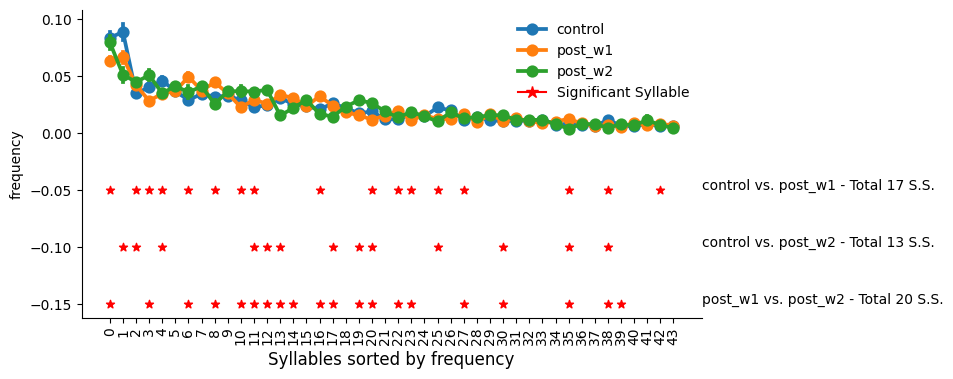

In [33]:
model_name="model_5e6_1e6"

kpms.plot_syll_stats_with_sem(
    moseq_3CT_stats,
    project_dir,
    model_name,
    plot_sig=True,  # whether to mark statistical significance with a star
    thresh=0.05,  # significance threshold
    stat="frequency",  # statistic to be plotted (e.g. 'duration' or 'velocity_px_s_mean')
    order="stat",  # order syllables by overall frequency ("stat") or degree of difference ("diff")
    #ctrl_group="a",  # name of the control group for statistical testing
    #exp_group="b",  # name of the experimental group for statistical testing
    figsize=(8, 4),  # figure size
    groups=moseq_3CT_stats["group"].unique(),  # groups to be plotted
);

In [ ]:
#new data

In [ ]:
# optionally rerun `save_results_as_csv` to export the new results
kpms.save_results_as_csv(results, project_dir, model_name="model_5e6_1e6")

In [ ]:
#load data (e.g from DeepLabCut)
new_data_nor = [
    '/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/NOR/crop',
    '/home/nj35/MRes/TDP videos/Cohort 1/post-induction-w1/NOR/crop',
    '/home/nj35/MRes/TDP videos/Cohort 1/post-induction-w2/NOR/crop',
    '/home/nj35/MRes/TDP videos/Cohort 3/pre-induction/NOR/crop',
    '/home/nj35/MRes/TDP videos/Cohort 3/post-induction-w1/NOR/crop',
    '/home/nj35/MRes/TDP videos/Cohort 3/post-induction-w2/NOR/crop'
] # can be a file, a directory, or a list of files